In [1]:
import os
import tqdm
import json
from tqdm import tqdm_notebook, notebook
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp
import numpy as np
import scipy as sc
import time
import copy
import random as rng
import lightgbm as lgb
import cython
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils import class_weight
from rankeval.metrics import Metric, NDCG, DCG, MAP
import rankeval
import rankeval.analysis.statistical
import rankeval.metrics
from rankeval.dataset import Dataset
from rankeval.model import RTEnsemble
from rankeval.analysis.feature import feature_importance
from scipy.stats import entropy as kld
import hyperopt
from hyperopt import base
import gc
import timeit
import sklearn as skl
import keras
from joblib import dump, load
import seaborn as sns
import itertools
from enum import Enum
from lightgbm.basic import LightGBMError
from rankeval.analysis.statistical import _randomization as random_test
import numpy, pandas, researchpy
base.have_bson = False
%load_ext Cython
%matplotlib inline
import scipy
print(scipy.__version__)

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

1.5.4


### Here we define the feautes used by the classifier and the classification label, the 'oracle'

In [2]:
def get_features(dataset, scores):
    n_dataset_features = dataset.n_features
    n_score_features = 4 # score, norm_score, rank, qsize
    n_features = n_dataset_features + n_score_features
    features = np.empty((dataset.n_instances, n_features ))
    rank_idx = np.zeros((dataset.n_instances,))
    for rel_id, (qid, start, end) in enumerate(dataset.query_iterator()):
        query_scores = scores[start:end]
        query_range = query_scores.max() - query_scores.min()
        norm_query_scores = (query_scores - query_scores.min()) / (query_range) if query_range != 0 else query_scores - query_scores.min()
        query_ranks = np.argsort(query_scores, kind='stable')[::-1]
        for rank, doc in enumerate(query_ranks):
            rank_idx[start + doc] = rank
        
        features[start:end, :n_dataset_features] = dataset.X[start:end, :]
        features[start:end, n_dataset_features + 0] = query_scores
        features[start:end, n_dataset_features + 1] = norm_query_scores
        features[start:end, n_dataset_features + 2] = rank_idx[start:end]
        features[start:end, n_dataset_features + 3] = end - start
    return features

def get_oracle(dataset, scores, k, sort_by_rel=False, detailed=False, filtered=True):
    mask = np.zeros(shape=(dataset.n_instances,))
    details = np.zeros(shape=(dataset.n_queries,))
    for rel_id, (qid, start, end) in enumerate(dataset.query_iterator()):
        query_mask = np.zeros(shape=(end-start,))
        true_rel = dataset.y[start : end]
        if not sort_by_rel:
            final_ranks = np.argsort(scores[start:end], kind='stable')[::-1]
        else:
            final_ranks = np.argsort(true_rel, kind='stable')[::-1]
        top_k = final_ranks[:k] if k < (end - start) else final_ranks[:]
        
        if filtered:
            top_k = np.array([r for r in top_k if true_rel[r] > 0 ], dtype=int)
        query_mask[top_k] = 1.0
        mask[start:end] = query_mask
        details[rel_id] = query_mask.sum()
    if detailed:
        return mask, details
    else:
        return mask


### The SDCG uses a stable sort, this makes it behave in the same way as Quickscorer which is in C++

In [3]:
class SDCG(Metric):

    def __init__(self, name='SDCG', cutoff=None, implementation="flat"):

        super(SDCG, self).__init__(name)
        self.cutoff = cutoff
        self.implementation = implementation

    def eval(self, dataset, y_pred):

        return super(SDCG, self).eval(dataset, y_pred)

    def eval_per_query(self, y, y_pred):
        idx_y_pred_sorted = np.argsort(y_pred,kind='stable')[::-1]
        if self.cutoff is not None:
            idx_y_pred_sorted = idx_y_pred_sorted[:self.cutoff]

        discount = np.log2(np.arange(2, idx_y_pred_sorted.size + 2))

        if self.implementation == "flat":
            gain = y[idx_y_pred_sorted]
        elif self.implementation == "exp":
            gain = np.exp2(y[idx_y_pred_sorted]) - 1.0

        dcg = (gain / discount).sum()
        return dcg

    def __str__(self):
        return self.name if self.cutoff is None else f'{self.name}@{self.cutoff}'

class SNDCG(Metric):

    def __init__(self, name='SNDCG', cutoff=None, no_relevant_results=1.0,
                 implementation="exp"):

        super(self.__class__, self).__init__(name)
        self.cutoff = cutoff
        self.no_relevant_results = no_relevant_results
        self.implementation = implementation
        self.dcg = SDCG(cutoff=self.cutoff,
                       implementation=self.implementation)

        self._current_dataset = None
        self._current_rel_qid = None
        self._cache_idcg_score = defaultdict(int)

    def eval(self, dataset, y_pred):
        # used to cache ideal DCG scores on a dataset basis
        self._current_dataset = dataset
        self._current_rel_qid = 0

        # Compute the ideal DCG scores only once and cache them
        if self._current_dataset not in self._cache_idcg_score:

            idcg_score = np.ndarray(shape=dataset.n_queries, dtype=np.float32)
            for rel_id, (qid, q_y, _) in enumerate(
                    self.query_iterator(dataset, dataset.y)):
                idcg_score[rel_id] = self.dcg.eval_per_query(q_y, q_y)

            self._cache_idcg_score[self._current_dataset] = idcg_score

        return super(self.__class__, self).eval(dataset, y_pred)

    def eval_per_query(self, y, y_pred):
        dcg_score = self.dcg.eval_per_query(y, y_pred)

        if self._current_rel_qid is not None:
            idcg_score = \
                self._cache_idcg_score[self._current_dataset][self._current_rel_qid]
            self._current_rel_qid += 1
        else:
            idcg_score = self.dcg.eval_per_query(y, y)

        if idcg_score != 0:
            ndcg = dcg_score / idcg_score
        else:
            ndcg = self.no_relevant_results
        return ndcg

    def __str__(self):
        return self.name if self.cutoff is None else f'{self.name}@{self.cutoff}'

    
class UnBuiltSentinelError(Exception):
    pass


class DummyTransformer():
    def __init__(self):
        self.isFitted = False
    def fit(self, D):
        self.isFitted = True
    def transform(self, D):
        return D
    def fit_transform(self, D):
        self.fit(D)
        return self.transform(D)





#### Define the dataset(s) location(s) and the random seed

In [4]:
istella_name = "ISTELLA-FULL"
msn_name = "MSN30KF1"
istella_path = '../datasets/ISTELLA/'
msn_path = '../datasets/MSLR/Fold1'
random_seed = 111

datasets_name = [msn_name, istella_name]
datasets_pairs = [(msn_name, msn_path),(istella_name, istella_path)]
rstate = np.random.RandomState(random_seed)

## Data Loading

### Datasets

In [5]:
rankeval_datasets = {}
for dataset_name, dataset_path in datasets_pairs:
    rankeval_datasets[dataset_name] = dict([
        (split, Dataset.load(os.path.join(dataset_path, split + '.txt'), name="{} {}".format(dataset_name, split.capitalize()))) for split in [ 'train', 'vali', 'test']
])

### Ranking models

In [6]:
rankeval_models_new = {}

for dataset_name in datasets_name:
    path_model = './data/rankers/gs_retrain-lgb-{}_ranker.txt'.format(dataset_name)
    rankeval_models_new[dataset_name] = RTEnsemble(path_model, format='LightGBM')

for dataset_name, model in rankeval_models_new.items():
    print('Model trained on {} has {} trees'.format(dataset_name,model.n_trees))

Model trained on MSN30KF1 has 1129 trees
Model trained on ISTELLA-FULL has 1481 trees


### Aux models, we also tried an aux trained to optimise for ndcg@20, ultimately we did not included in the paper

In [7]:
rankeval_models_aux10 = {}
rankeval_models_aux20 = {}

for dataset_name in datasets_name:
    path_model_10 = './data/rankers/gs50_aux_10_{}.txt'.format(dataset_name)
    path_model_20 = './data/rankers/gs_aux_20_{}.txt'.format(dataset_name)
    rankeval_models_aux10[dataset_name] = RTEnsemble(path_model_10, format='LightGBM')
    rankeval_models_aux20[dataset_name] = RTEnsemble(path_model_20, format='LightGBM')

for dataset_name, model in rankeval_models_aux10.items():
    print('Model trained on {} for ndcg@10 has {} trees'.format(dataset_name,model.n_trees))

for dataset_name, model in rankeval_models_aux20.items():
    print('Model trained on {} for ndcg@20 has {} trees'.format(dataset_name,model.n_trees))

Model trained on MSN30KF1 for ndcg@10 has 50 trees
Model trained on ISTELLA-FULL for ndcg@10 has 50 trees
Model trained on MSN30KF1 for ndcg@20 has 89 trees
Model trained on ISTELLA-FULL for ndcg@20 has 100 trees


In [8]:
classification_datasets = {}
for dataset_name in datasets_name:
    classification_datasets[dataset_name] = {}
    classification_datasets[dataset_name]['test'] = rankeval_datasets[dataset_name]['test']
    classification_datasets[dataset_name]['train'], classification_datasets[dataset_name]['vali'] = rankeval_datasets[dataset_name]['vali'].split(train_size=0.80, random_state=rstate)

### Precompute tree by tree scores of both main ranking model and aux

In [9]:
y_pred_rankeval = {}
y_pred_along_training = {}
execution_time = {}

for dataset_name in tqdm.notebook.tqdm(datasets_name, leave=False, desc="Datasets"):
    
    y_pred_rankeval[dataset_name] = {}
    y_pred_along_training[dataset_name] = {}
    execution_time[dataset_name] = {}
    
    for split in tqdm.notebook.tqdm(rankeval_datasets[dataset_name], leave=False):
        start_t = timeit.default_timer()
        y_pred_rankeval[dataset_name][split], y_partial_pred, _ = rankeval_models_new[dataset_name].score(classification_datasets[dataset_name][split], detailed=True)
        elapsed = timeit.default_timer() - start_t
        y_pred_along_training[dataset_name][split] = y_partial_pred.cumsum(axis=1)
        execution_time[dataset_name][split] = elapsed

Datasets:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
y_pred_rankeval_aux_10 = {}
y_pred_along_training_aux_10 = {}
execution_time_aux_10 = {}
y_pred_rankeval_aux_20 = {}
y_pred_along_training_aux_20 = {}
execution_time_aux_20 = {}
for dataset_name in tqdm.notebook.tqdm(datasets_name, leave=False, desc="Datasets"):
    
    y_pred_rankeval_aux_10[dataset_name] = {}
    y_pred_along_training_aux_10[dataset_name] = {}
    execution_time_aux_10[dataset_name] = {}
    y_pred_rankeval_aux_20[dataset_name] = {}
    y_pred_along_training_aux_20[dataset_name] = {}
    execution_time_aux_20[dataset_name] = {}
    
    for split in tqdm.notebook.tqdm(rankeval_datasets[dataset_name], leave=False):
        start_t = timeit.default_timer()
        y_pred_rankeval_aux_10[dataset_name][split], y_partial_pred, _ = rankeval_models_aux10[dataset_name].score(classification_datasets[dataset_name][split], detailed=True)
        elapsed = timeit.default_timer() - start_t
        
        y_pred_along_training_aux_10[dataset_name][split] = y_partial_pred.cumsum(axis=1)
        execution_time_aux_10[dataset_name][split] = elapsed
        
        start_t = timeit.default_timer()
        y_pred_rankeval_aux_20[dataset_name][split], y_partial_pred, _ = rankeval_models_aux20[dataset_name].score(classification_datasets[dataset_name][split], detailed=True)
        elapsed = timeit.default_timer() - start_t
        
        y_pred_along_training_aux_20[dataset_name][split] = y_partial_pred.cumsum(axis=1)
        execution_time_aux_20[dataset_name][split] = elapsed

Datasets:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
rankeval_datasets = None
gc.collect()

142

In [12]:
dcg_10 = SDCG(cutoff=10, implementation='exp')
ndcg_10 = SNDCG(cutoff=10, implementation='exp', no_relevant_results=1.0)

In [13]:
class EmptyModel():
    
    def predict(X):
        return np.ones((X.shape[0],), dtype=np.float)

class Strategy(Enum):
    SENT = 1
    AUX = 4
    pass



### Load the classifiers trained before, one for each strategy (aux and sent) and position (50,100, 200)

In [14]:
lgb_classifiers = {}
for dataset_name in tqdm.notebook.tqdm(datasets_name):
    lgb_classifiers[dataset_name] = {}
    for strategy in Strategy:
        lgb_classifiers[dataset_name][strategy] = {}
        for position in tqdm.notebook.tqdm([50, 100, 200]):
            lgb_classifiers[dataset_name][strategy][position] = {}
            for k in tqdm.notebook.tqdm([10]):
                try:
                    model = lgb.Booster(model_file=f'./data/classifiers/GS_{dataset_name}_{strategy}_{position}_{k}_CLF.txt')
                except LightGBMError:
                    try:
                        model = lgb.Booster(model_file=f'./data/classifiers/GS_{dataset_name}_{strategy}_{position}_{k}_CLF.txt')
                    except LightGBMError:
                        model = EmptyModel()
                finally:
                    lgb_classifiers[dataset_name][strategy][position][k] = model

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
def progressbar(iterable, name=''):
    return tqdm.notebook.tqdm(iterable, desc=name, leave=False)

def mask_scores(mask, initial_scores, final_scores):
    mscores = final_scores.copy()
    mscores[~mask] = initial_scores[~mask] - 1000
    return mscores

In [16]:
k_set = [10]
positions = [50, 100, 200]

In [17]:
def EPT_mask(dataset, scores, k, pt):
    mask = np.zeros((dataset.n_instances,), dtype=np.bool)
    for rel_id, (qid, start, end) in enumerate(dataset.query_iterator()):
        query_scores = scores[start:end]
        query_ranks = np.argsort(query_scores, kind='stable')[::-1]
        top_k = query_ranks[:k]
        kth_doc = top_k[-1]
        kth_score = query_scores[kth_doc]
        score_threshold = kth_score - pt
        query_mask = query_scores >= score_threshold
        mask[start:end] = query_mask
    return mask

In [18]:
split = 'vali'
alpha=0.05
k_s = 10
colors_ept = {50: 'blue', 100: 'red', 200: 'green', 'aux': 'orange'}
colors_lear = {50: 'steelblue', 100: 'crimson', 200: 'darkgreen', 'aux': 'gold'}

In [19]:
dcg_10 = SDCG(cutoff=10, implementation='exp')
ndcg_10 = SNDCG(cutoff=10, implementation='exp', no_relevant_results=1.0)

In [20]:
from statsmodels.stats.weightstats import ttost_ind
from statsmodels.stats.weightstats import ttest_ind as ptest
#from rankeval.analysis.statistical import _randomization as ptest

In [21]:
# import libraries
import pandas
import numpy
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

def compute_CI(reference, experiment, scale=1, B=1000, alpha=0.95):
    x = reference - experiment
    # configure bootstrap
    n_iterations = B # here k=no. of bootstrapped samples
    n_size = int(len(x))

    # run bootstrap
    medians = []
    for i in range(n_iterations):
        s = resample(x, n_samples=n_size);
        m = numpy.median(s);
        medians.append(m)

    # plot scores
    #plt.hist(medians)
    #plt.show()

    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower =  numpy.percentile(medians, p)
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper =  numpy.percentile(medians, p)

    return lower, upper

### Best overall k comparison

In [23]:
dcg_10 = SDCG(cutoff=10, implementation='exp')
ndcg_10 = SNDCG(cutoff=10, implementation='exp', no_relevant_results=1.0)

  0%|          | 0/2 [00:00<?, ?it/s]

----------AUX-----------


  0%|          | 0/20 [00:00<?, ?it/s]

EPT Strategy.AUX 0.30:: 0.5290 (-0.44%) 5.18x
EPT Strategy.AUX 0.36:: 0.5299 (-0.26%) 4.73x
EPT Strategy.AUX 0.43:: 0.5303 (-0.18%) 4.33x
EPT Strategy.AUX 0.49:: 0.5305 (-0.15%) 3.97x
EPT Strategy.AUX 0.55:: 0.5305 (-0.15%) 3.65x
EPT Strategy.AUX 0.62:: 0.5308 (-0.10%) 3.36x
EPT Strategy.AUX 0.68:: 0.5308 (-0.09%) 3.09x
EPT Strategy.AUX 0.74:: 0.5307 (-0.11%) 2.85x
EPT Strategy.AUX 0.81:: 0.5308 (-0.10%) 2.64x
EPT Strategy.AUX 0.87:: 0.5310 (-0.06%) 2.46x
EPT Strategy.AUX 0.93:: 0.5312 (-0.03%) 2.29x
EPT Strategy.AUX 0.99:: 0.5312 (-0.02%) 2.15x
EPT Strategy.AUX 1.06:: 0.5313 (0.00%) 2.02x
EPT Strategy.AUX 1.12:: 0.5313 (0.00%) 1.90x
EPT Strategy.AUX 1.18:: 0.5313 (-0.00%) 1.79x
EPT Strategy.AUX 1.25:: 0.5313 (-0.00%) 1.70x
EPT Strategy.AUX 1.31:: 0.5313 (-0.00%) 1.62x
EPT Strategy.AUX 1.37:: 0.5313 (-0.00%) 1.54x
EPT Strategy.AUX 1.44:: 0.5313 (-0.00%) 1.47x
EPT Strategy.AUX 1.50:: 0.5313 (-0.00%) 1.42x


  0%|          | 0/3 [00:00<?, ?it/s]

-----50-------


  0%|          | 0/20 [00:00<?, ?it/s]

EPT 50 0.30:: 0.5272 (-0.77%) 4.18x
EPT 50 0.36:: 0.5280 (-0.63%) 3.65x
EPT 50 0.43:: 0.5288 (-0.46%) 3.22x
EPT 50 0.49:: 0.5290 (-0.43%) 2.86x
EPT 50 0.55:: 0.5295 (-0.34%) 2.56x
EPT 50 0.62:: 0.5299 (-0.27%) 2.31x
EPT 50 0.68:: 0.5303 (-0.18%) 2.10x
EPT 50 0.74:: 0.5304 (-0.18%) 1.93x
EPT 50 0.81:: 0.5304 (-0.16%) 1.78x
EPT 50 0.87:: 0.5305 (-0.14%) 1.65x
EPT 50 0.93:: 0.5308 (-0.10%) 1.54x
EPT 50 0.99:: 0.5308 (-0.10%) 1.45x
EPT 50 1.06:: 0.5308 (-0.10%) 1.38x
EPT 50 1.12:: 0.5308 (-0.10%) 1.31x
EPT 50 1.18:: 0.5308 (-0.10%) 1.26x
EPT 50 1.25:: 0.5308 (-0.10%) 1.22x
EPT 50 1.31:: 0.5308 (-0.10%) 1.18x
EPT 50 1.37:: 0.5308 (-0.10%) 1.15x
EPT 50 1.44:: 0.5308 (-0.10%) 1.13x
EPT 50 1.50:: 0.5308 (-0.10%) 1.11x
-----100-------


  0%|          | 0/20 [00:00<?, ?it/s]

EPT 100 0.30:: 0.5293 (-0.37%) 4.13x
EPT 100 0.36:: 0.5292 (-0.40%) 3.79x
EPT 100 0.43:: 0.5295 (-0.34%) 3.48x
EPT 100 0.49:: 0.5301 (-0.23%) 3.19x
EPT 100 0.55:: 0.5303 (-0.18%) 2.94x
EPT 100 0.62:: 0.5304 (-0.17%) 2.71x
EPT 100 0.68:: 0.5304 (-0.18%) 2.50x
EPT 100 0.74:: 0.5305 (-0.15%) 2.32x
EPT 100 0.81:: 0.5305 (-0.14%) 2.16x
EPT 100 0.87:: 0.5307 (-0.11%) 2.02x
EPT 100 0.93:: 0.5308 (-0.09%) 1.89x
EPT 100 0.99:: 0.5308 (-0.09%) 1.78x
EPT 100 1.06:: 0.5308 (-0.09%) 1.68x
EPT 100 1.12:: 0.5308 (-0.10%) 1.59x
EPT 100 1.18:: 0.5308 (-0.10%) 1.52x
EPT 100 1.25:: 0.5312 (-0.01%) 1.45x
EPT 100 1.31:: 0.5312 (-0.01%) 1.39x
EPT 100 1.37:: 0.5313 (-0.00%) 1.34x
EPT 100 1.44:: 0.5313 (-0.00%) 1.29x
EPT 100 1.50:: 0.5313 (-0.00%) 1.25x
-----200-------


  0%|          | 0/20 [00:00<?, ?it/s]

EPT 200 0.30:: 0.5294 (-0.36%) 3.31x
EPT 200 0.36:: 0.5304 (-0.18%) 3.14x
EPT 200 0.43:: 0.5306 (-0.13%) 2.99x
EPT 200 0.49:: 0.5307 (-0.11%) 2.83x
EPT 200 0.55:: 0.5306 (-0.13%) 2.68x
EPT 200 0.62:: 0.5311 (-0.04%) 2.54x
EPT 200 0.68:: 0.5311 (-0.03%) 2.40x
EPT 200 0.74:: 0.5311 (-0.03%) 2.28x
EPT 200 0.81:: 0.5313 (-0.01%) 2.15x
EPT 200 0.87:: 0.5313 (-0.01%) 2.04x
EPT 200 0.93:: 0.5313 (-0.00%) 1.94x
EPT 200 0.99:: 0.5313 (-0.00%) 1.85x
EPT 200 1.06:: 0.5313 (-0.00%) 1.76x
EPT 200 1.12:: 0.5313 (-0.00%) 1.68x
EPT 200 1.18:: 0.5313 (-0.00%) 1.61x
EPT 200 1.25:: 0.5313 (-0.00%) 1.55x
EPT 200 1.31:: 0.5313 (-0.00%) 1.49x
EPT 200 1.37:: 0.5313 (-0.00%) 1.43x
EPT 200 1.44:: 0.5313 (-0.00%) 1.38x
EPT 200 1.50:: 0.5313 (-0.00%) 1.34x


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


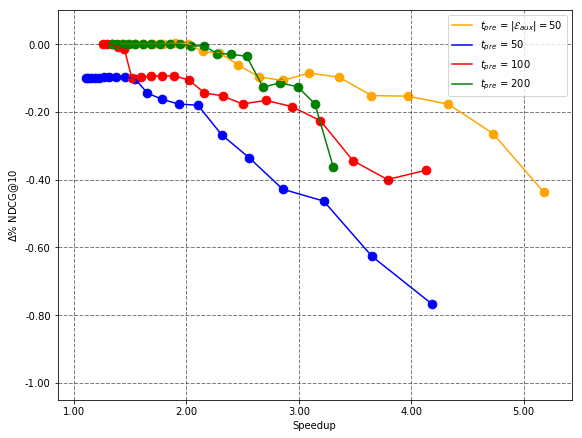

----------AUX-----------


  0%|          | 0/20 [00:00<?, ?it/s]

EPT Strategy.AUX 0.30:: 0.7240 (-0.95%) 13.74x
EPT Strategy.AUX 0.36:: 0.7255 (-0.75%) 13.47x
EPT Strategy.AUX 0.43:: 0.7262 (-0.65%) 13.20x
EPT Strategy.AUX 0.49:: 0.7267 (-0.58%) 12.95x
EPT Strategy.AUX 0.55:: 0.7275 (-0.47%) 12.70x
EPT Strategy.AUX 0.62:: 0.7285 (-0.33%) 12.44x
EPT Strategy.AUX 0.68:: 0.7287 (-0.30%) 12.20x
EPT Strategy.AUX 0.74:: 0.7285 (-0.33%) 11.92x
EPT Strategy.AUX 0.81:: 0.7287 (-0.30%) 11.67x
EPT Strategy.AUX 0.87:: 0.7291 (-0.25%) 11.42x
EPT Strategy.AUX 0.93:: 0.7293 (-0.22%) 11.20x
EPT Strategy.AUX 0.99:: 0.7295 (-0.20%) 10.98x
EPT Strategy.AUX 1.06:: 0.7296 (-0.19%) 10.76x
EPT Strategy.AUX 1.12:: 0.7302 (-0.10%) 10.53x
EPT Strategy.AUX 1.18:: 0.7303 (-0.09%) 10.32x
EPT Strategy.AUX 1.25:: 0.7302 (-0.10%) 10.10x
EPT Strategy.AUX 1.31:: 0.7300 (-0.13%) 9.88x
EPT Strategy.AUX 1.37:: 0.7300 (-0.12%) 9.68x
EPT Strategy.AUX 1.44:: 0.7299 (-0.14%) 9.46x
EPT Strategy.AUX 1.50:: 0.7301 (-0.12%) 9.25x


  0%|          | 0/3 [00:00<?, ?it/s]

-----50-------


  0%|          | 0/20 [00:00<?, ?it/s]

EPT 50 0.30:: 0.7117 (-2.64%) 12.77x
EPT 50 0.36:: 0.7149 (-2.19%) 12.31x
EPT 50 0.43:: 0.7172 (-1.89%) 11.85x
EPT 50 0.49:: 0.7196 (-1.55%) 11.38x
EPT 50 0.55:: 0.7213 (-1.32%) 10.95x
EPT 50 0.62:: 0.7223 (-1.18%) 10.54x
EPT 50 0.68:: 0.7233 (-1.05%) 10.15x
EPT 50 0.74:: 0.7243 (-0.90%) 9.74x
EPT 50 0.81:: 0.7253 (-0.78%) 9.37x
EPT 50 0.87:: 0.7255 (-0.75%) 9.00x
EPT 50 0.93:: 0.7270 (-0.54%) 8.65x
EPT 50 0.99:: 0.7275 (-0.47%) 8.29x
EPT 50 1.06:: 0.7277 (-0.44%) 7.96x
EPT 50 1.12:: 0.7281 (-0.38%) 7.64x
EPT 50 1.18:: 0.7290 (-0.27%) 7.33x
EPT 50 1.25:: 0.7298 (-0.16%) 7.05x
EPT 50 1.31:: 0.7300 (-0.13%) 6.77x
EPT 50 1.37:: 0.7302 (-0.10%) 6.52x
EPT 50 1.44:: 0.7302 (-0.11%) 6.27x
EPT 50 1.50:: 0.7304 (-0.07%) 6.02x
-----100-------


  0%|          | 0/20 [00:00<?, ?it/s]

EPT 100 0.30:: 0.7187 (-1.67%) 9.37x
EPT 100 0.36:: 0.7200 (-1.50%) 9.19x
EPT 100 0.43:: 0.7209 (-1.37%) 9.02x
EPT 100 0.49:: 0.7220 (-1.22%) 8.84x
EPT 100 0.55:: 0.7225 (-1.15%) 8.66x
EPT 100 0.62:: 0.7237 (-0.99%) 8.48x
EPT 100 0.68:: 0.7248 (-0.84%) 8.31x
EPT 100 0.74:: 0.7259 (-0.69%) 8.13x
EPT 100 0.81:: 0.7269 (-0.56%) 7.97x
EPT 100 0.87:: 0.7273 (-0.49%) 7.80x
EPT 100 0.93:: 0.7279 (-0.41%) 7.65x
EPT 100 0.99:: 0.7285 (-0.34%) 7.49x
EPT 100 1.06:: 0.7290 (-0.26%) 7.32x
EPT 100 1.12:: 0.7292 (-0.23%) 7.17x
EPT 100 1.18:: 0.7294 (-0.21%) 7.02x
EPT 100 1.25:: 0.7296 (-0.19%) 6.86x
EPT 100 1.31:: 0.7301 (-0.11%) 6.71x
EPT 100 1.37:: 0.7305 (-0.07%) 6.56x
EPT 100 1.44:: 0.7305 (-0.06%) 6.41x
EPT 100 1.50:: 0.7305 (-0.06%) 6.26x
-----200-------


  0%|          | 0/20 [00:00<?, ?it/s]

EPT 200 0.30:: 0.7248 (-0.84%) 5.89x
EPT 200 0.36:: 0.7254 (-0.76%) 5.84x
EPT 200 0.43:: 0.7267 (-0.59%) 5.79x
EPT 200 0.49:: 0.7269 (-0.55%) 5.74x
EPT 200 0.55:: 0.7277 (-0.45%) 5.68x
EPT 200 0.62:: 0.7281 (-0.39%) 5.63x
EPT 200 0.68:: 0.7282 (-0.37%) 5.57x
EPT 200 0.74:: 0.7286 (-0.32%) 5.51x
EPT 200 0.81:: 0.7288 (-0.29%) 5.46x
EPT 200 0.87:: 0.7295 (-0.20%) 5.40x
EPT 200 0.93:: 0.7298 (-0.16%) 5.35x
EPT 200 0.99:: 0.7301 (-0.12%) 5.30x
EPT 200 1.06:: 0.7300 (-0.13%) 5.24x
EPT 200 1.12:: 0.7303 (-0.09%) 5.18x
EPT 200 1.18:: 0.7304 (-0.07%) 5.12x
EPT 200 1.25:: 0.7305 (-0.05%) 5.07x
EPT 200 1.31:: 0.7306 (-0.04%) 5.01x
EPT 200 1.37:: 0.7306 (-0.04%) 4.95x
EPT 200 1.44:: 0.7306 (-0.05%) 4.89x
EPT 200 1.50:: 0.7308 (-0.02%) 4.83x


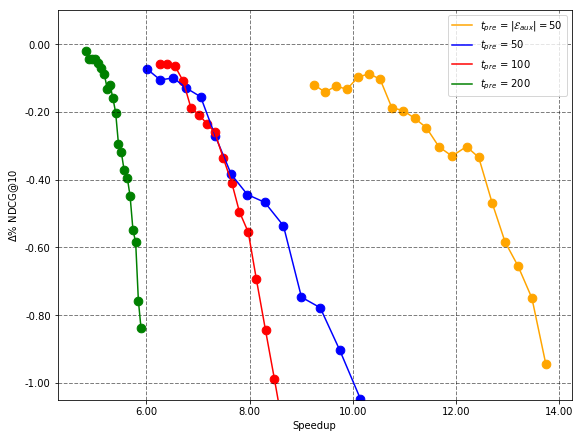

In [24]:
for dataset_name in progressbar(datasets_name):
    dataset = classification_datasets[dataset_name][split]
    end_scores = y_pred_along_training[dataset_name][split][:, -1]
    n = dataset.n_instances
    m = y_pred_along_training[dataset_name][split].shape[1]
    aux_t = y_pred_along_training_aux_10[dataset_name][split].shape[1]
    base_cost = n * m
    base_perf = ndcg_10.eval(dataset, end_scores)
    sentinel_scores = y_pred_along_training_aux_10[dataset_name][split][:, -1]
    speedups, metrics, stat_diffs = [], [], []
    plt.figure(figsize=(8,6))
    print('----------AUX-----------')
    for pt in progressbar(np.linspace(0.3, 1.5, 20)):
        y_pred = EPT_mask(dataset, sentinel_scores, k=10, pt=pt)
        n_C = y_pred.sum()
        masked_scores = mask_scores(y_pred, sentinel_scores, end_scores)
        cost = n * aux_t + n_C * m 
        perf = ndcg_10.eval(dataset, masked_scores)
        speedup = base_cost / cost
        delta = -100 * (base_perf[0] - perf[0])/base_perf[0]
        
        pvalue = ptest(base_perf[1], perf[1])[1]
        stat_diff = pvalue < alpha
        stat_diffs.append(stat_diff)
        speedups.append(speedup)
        metrics.append(delta)
        print(f'EPT {strategy} {pt:.2f}:: {perf[0]:.4f} ({delta:.2f}%) {speedup:.2f}x')
    stat_diffs = np.array(stat_diffs)
    speedups = np.array(speedups)
    metrics = np.array(metrics)
    plt.plot(speedups, metrics, label=rf'$t_{{pre}}$ = $|\mathcal{{E}}_{{aux}}| = 50$', markersize=10, color=colors_ept['aux'])
    plt.scatter(speedups[stat_diffs], metrics[stat_diffs], marker='d', s=75, c=colors_ept['aux'])
    plt.scatter(speedups[~stat_diffs], metrics[~stat_diffs], marker='o', s=75, c = colors_ept['aux'])
    
    
    for position in progressbar(positions):
        print(f'-----{position}-------')
        sentinel_scores = y_pred_along_training[dataset_name][split][:, position-1]
        speedups, metrics, stat_diffs = [], [], []
        for pt in progressbar(np.linspace(0.3, 1.5, 20)):
            y_pred = EPT_mask(dataset, sentinel_scores, k=10, pt=pt)
            n_C = y_pred.sum()
            masked_scores = mask_scores(y_pred, sentinel_scores, end_scores)
            cost = n * position +  n_C * (m - position) 
            perf = ndcg_10.eval(dataset, masked_scores)
            speedup = base_cost / cost
            delta = -100 * (base_perf[0] - perf[0])/base_perf[0]
            speedups.append(speedup)
            metrics.append(delta)
            pvalue = ptest(base_perf[1], perf[1])[1]
            stat_diff = pvalue < alpha
            stat_diffs.append(stat_diff)
            print(f'EPT {position} {pt:.2f}:: {perf[0]:.4f} ({delta:.2f}%) {speedup:.2f}x')
        stat_diffs = np.array(stat_diffs)
        speedups = np.array(speedups)
        metrics = np.array(metrics)
        plt.plot(speedups, metrics, label=rf'$t_{{pre}}$ = {position}', color=colors_ept[position])
        plt.scatter(speedups[stat_diffs], metrics[stat_diffs], marker='d', s=75, c=colors_ept[position])
        plt.scatter(speedups[~stat_diffs], metrics[~stat_diffs], marker='o', s=75, c = colors_ept[position])
    
    plt.ylim(( -1.05, 0.1))
    plt.legend()
    plt.grid(color='black', linestyle='--', linewidth=1, alpha=0.5)
    plt.xlabel('Speedup')
    plt.ylabel(r'$\Delta$% NDCG@10')
    
    
    y_ticks = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:.2f}'.format(x) for x in y_ticks])
    
    x_ticks = plt.gca().get_xticks()
    plt.gca().set_xticklabels(['{:.2f}'.format(x) for x in x_ticks])
    
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.savefig(f'./images/ept_aux_{dataset_name}.pdf', format='pdf', bbox_inches = "tight")
    plt.show()

### From values coming from above select positions and thresholds

In [25]:
best_positions ={
    msn_name: {
        'EPT' :{
            Strategy.SENT: 200,
            Strategy.AUX:  50
        }
    },
    istella_name: {
        'EPT' :{
            Strategy.SENT: 100,
            Strategy.AUX:  50
        }
    },
}

best_thresholds = {
    msn_name: {
        'EPT' :{
            Strategy.SENT: [0.36, 0.42 ],
            Strategy.AUX:  [0.36, 0.42 ]
        }
    },
    istella_name: {
        'EPT' :{
            Strategy.SENT: [1.37, 1.50 ],
            Strategy.AUX:  [1.12, 1.25 ]
        }
    },
}

#### Fix k_s = 10. Choose sentinel postion for EPT_prefix and LEAR_prefix on the vaii set

In [27]:
k_s = 10

In [28]:
dcg_10 = SDCG(cutoff=10, implementation='exp')
ndcg_10 = SNDCG(cutoff=10, implementation='exp', no_relevant_results=1.0)

In [29]:
lgb_classifiers

{'MSN30KF1': {<Strategy.SENT: 1>: {50: {10: <lightgbm.basic.Booster at 0x7f3d9ed70518>},
   100: {10: <lightgbm.basic.Booster at 0x7f3d9edd5908>},
   200: {10: <lightgbm.basic.Booster at 0x7f3d9edd5390>}},
  <Strategy.AUX: 4>: {50: {10: <lightgbm.basic.Booster at 0x7f3d9ee25198>},
   100: {10: <lightgbm.basic.Booster at 0x7f3d9ee1d710>},
   200: {10: <__main__.EmptyModel at 0x7f3d9ee1df28>}}},
 'ISTELLA-FULL': {<Strategy.SENT: 1>: {50: {10: <lightgbm.basic.Booster at 0x7f3d9ed473c8>},
   100: {10: <lightgbm.basic.Booster at 0x7f3d9eccc470>},
   200: {10: <lightgbm.basic.Booster at 0x7f3d9eccc9b0>}},
  <Strategy.AUX: 4>: {50: {10: <lightgbm.basic.Booster at 0x7f3d9ece27f0>},
   100: {10: <lightgbm.basic.Booster at 0x7f3d9ece2e48>},
   200: {10: <__main__.EmptyModel at 0x7f3d9ec7e630>}}}}

#### Lear aux

In [30]:
dcg_10 = SDCG(cutoff=10, implementation='exp')
ndcg_10 = SNDCG(cutoff=10, implementation='exp', no_relevant_results=1.0)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

--------50-----------


  0%|          | 0/20 [00:00<?, ?it/s]

LEAR 50 0.10:: 0.5315 (0.04%) 2.75x
LEAR 50 0.14:: 0.5313 (0.00%) 2.94x
LEAR 50 0.18:: 0.5313 (0.01%) 3.10x
LEAR 50 0.23:: 0.5313 (-0.00%) 3.24x
LEAR 50 0.27:: 0.5316 (0.07%) 3.36x
LEAR 50 0.31:: 0.5314 (0.02%) 3.47x
LEAR 50 0.35:: 0.5318 (0.09%) 3.59x
LEAR 50 0.39:: 0.5323 (0.19%) 3.70x
LEAR 50 0.44:: 0.5328 (0.28%) 3.82x
LEAR 50 0.48:: 0.5329 (0.30%) 3.94x
LEAR 50 0.52:: 0.5329 (0.30%) 4.06x
LEAR 50 0.56:: 0.5327 (0.27%) 4.19x
LEAR 50 0.61:: 0.5329 (0.30%) 4.33x
LEAR 50 0.65:: 0.5330 (0.33%) 4.49x
LEAR 50 0.69:: 0.5330 (0.32%) 4.68x
LEAR 50 0.73:: 0.5322 (0.17%) 4.89x
LEAR 50 0.77:: 0.5311 (-0.03%) 5.13x
LEAR 50 0.82:: 0.5293 (-0.37%) 5.44x
LEAR 50 0.86:: 0.5271 (-0.79%) 5.87x
LEAR 50 0.90:: 0.5252 (-1.15%) 6.48x
--------100-----------


  0%|          | 0/20 [00:00<?, ?it/s]

LEAR 100 0.10:: 0.5315 (0.04%) 2.74x
LEAR 100 0.14:: 0.5317 (0.08%) 2.90x
LEAR 100 0.18:: 0.5319 (0.12%) 3.03x
LEAR 100 0.23:: 0.5317 (0.08%) 3.14x
LEAR 100 0.27:: 0.5320 (0.14%) 3.24x
LEAR 100 0.31:: 0.5321 (0.15%) 3.33x
LEAR 100 0.35:: 0.5320 (0.14%) 3.42x
LEAR 100 0.39:: 0.5323 (0.19%) 3.50x
LEAR 100 0.44:: 0.5321 (0.16%) 3.58x
LEAR 100 0.48:: 0.5320 (0.12%) 3.66x
LEAR 100 0.52:: 0.5319 (0.12%) 3.74x
LEAR 100 0.56:: 0.5321 (0.15%) 3.83x
LEAR 100 0.61:: 0.5324 (0.21%) 3.91x
LEAR 100 0.65:: 0.5325 (0.24%) 4.01x
LEAR 100 0.69:: 0.5322 (0.17%) 4.12x
LEAR 100 0.73:: 0.5320 (0.13%) 4.25x
LEAR 100 0.77:: 0.5315 (0.04%) 4.40x
LEAR 100 0.82:: 0.5324 (0.21%) 4.58x
LEAR 100 0.86:: 0.5309 (-0.07%) 4.82x
LEAR 100 0.90:: 0.5303 (-0.19%) 5.15x
--------200-----------


  0%|          | 0/20 [00:00<?, ?it/s]

LEAR 200 0.10:: 0.5314 (0.03%) 2.76x
LEAR 200 0.14:: 0.5314 (0.01%) 2.84x
LEAR 200 0.18:: 0.5314 (0.01%) 2.90x
LEAR 200 0.23:: 0.5314 (0.02%) 2.95x
LEAR 200 0.27:: 0.5318 (0.09%) 2.99x
LEAR 200 0.31:: 0.5319 (0.11%) 3.03x
LEAR 200 0.35:: 0.5319 (0.11%) 3.07x
LEAR 200 0.39:: 0.5318 (0.11%) 3.11x
LEAR 200 0.44:: 0.5316 (0.06%) 3.14x
LEAR 200 0.48:: 0.5317 (0.08%) 3.18x
LEAR 200 0.52:: 0.5316 (0.07%) 3.21x
LEAR 200 0.56:: 0.5316 (0.06%) 3.25x
LEAR 200 0.61:: 0.5321 (0.15%) 3.28x
LEAR 200 0.65:: 0.5317 (0.09%) 3.32x
LEAR 200 0.69:: 0.5322 (0.18%) 3.36x
LEAR 200 0.73:: 0.5322 (0.17%) 3.41x
LEAR 200 0.77:: 0.5320 (0.13%) 3.47x
LEAR 200 0.82:: 0.5319 (0.12%) 3.54x
LEAR 200 0.86:: 0.5317 (0.08%) 3.63x
LEAR 200 0.90:: 0.5309 (-0.07%) 3.74x
-----AUX------


  0%|          | 0/20 [00:00<?, ?it/s]

LEAR Strategy.AUX 0.10:: 0.5315 (0.04%) 3.07x
LEAR Strategy.AUX 0.14:: 0.5313 (-0.00%) 3.27x
LEAR Strategy.AUX 0.18:: 0.5315 (0.03%) 3.44x
LEAR Strategy.AUX 0.23:: 0.5317 (0.08%) 3.57x
LEAR Strategy.AUX 0.27:: 0.5319 (0.12%) 3.68x
LEAR Strategy.AUX 0.31:: 0.5316 (0.06%) 3.79x
LEAR Strategy.AUX 0.35:: 0.5316 (0.06%) 3.90x
LEAR Strategy.AUX 0.39:: 0.5318 (0.10%) 3.99x
LEAR Strategy.AUX 0.44:: 0.5320 (0.13%) 4.10x
LEAR Strategy.AUX 0.48:: 0.5319 (0.11%) 4.20x
LEAR Strategy.AUX 0.52:: 0.5318 (0.10%) 4.31x
LEAR Strategy.AUX 0.56:: 0.5321 (0.15%) 4.43x
LEAR Strategy.AUX 0.61:: 0.5323 (0.20%) 4.56x
LEAR Strategy.AUX 0.65:: 0.5318 (0.09%) 4.69x
LEAR Strategy.AUX 0.69:: 0.5319 (0.12%) 4.83x
LEAR Strategy.AUX 0.73:: 0.5315 (0.04%) 5.02x
LEAR Strategy.AUX 0.77:: 0.5311 (-0.03%) 5.23x
LEAR Strategy.AUX 0.82:: 0.5307 (-0.12%) 5.48x
LEAR Strategy.AUX 0.86:: 0.5299 (-0.26%) 5.83x
LEAR Strategy.AUX 0.90:: 0.5276 (-0.70%) 6.37x
---------


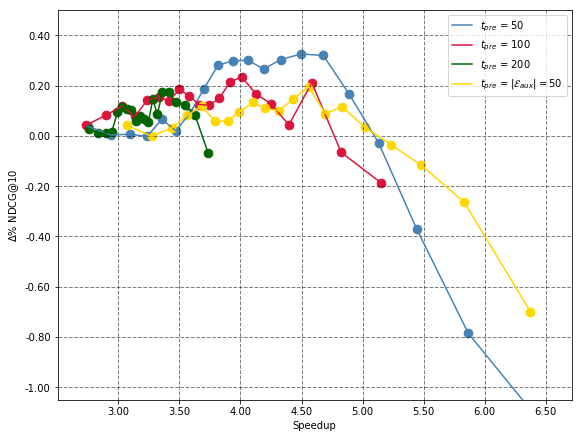

  0%|          | 0/3 [00:00<?, ?it/s]

--------50-----------


  0%|          | 0/20 [00:00<?, ?it/s]

LEAR 50 0.10:: 0.7304 (-0.07%) 5.19x
LEAR 50 0.14:: 0.7302 (-0.10%) 5.57x
LEAR 50 0.18:: 0.7298 (-0.15%) 5.87x
LEAR 50 0.23:: 0.7296 (-0.18%) 6.12x
LEAR 50 0.27:: 0.7296 (-0.19%) 6.33x
LEAR 50 0.31:: 0.7294 (-0.21%) 6.53x
LEAR 50 0.35:: 0.7296 (-0.19%) 6.72x
LEAR 50 0.39:: 0.7294 (-0.21%) 6.90x
LEAR 50 0.44:: 0.7285 (-0.33%) 7.07x
LEAR 50 0.48:: 0.7282 (-0.38%) 7.25x
LEAR 50 0.52:: 0.7278 (-0.43%) 7.44x
LEAR 50 0.56:: 0.7276 (-0.46%) 7.63x
LEAR 50 0.61:: 0.7271 (-0.52%) 7.80x
LEAR 50 0.65:: 0.7268 (-0.56%) 7.99x
LEAR 50 0.69:: 0.7262 (-0.65%) 8.19x
LEAR 50 0.73:: 0.7258 (-0.71%) 8.44x
LEAR 50 0.77:: 0.7253 (-0.77%) 8.69x
LEAR 50 0.82:: 0.7252 (-0.79%) 9.00x
LEAR 50 0.86:: 0.7242 (-0.93%) 9.40x
LEAR 50 0.90:: 0.7231 (-1.07%) 9.98x
--------100-----------


  0%|          | 0/20 [00:00<?, ?it/s]

LEAR 100 0.10:: 0.7304 (-0.07%) 5.18x
LEAR 100 0.14:: 0.7303 (-0.09%) 5.45x
LEAR 100 0.18:: 0.7302 (-0.10%) 5.65x
LEAR 100 0.23:: 0.7302 (-0.11%) 5.81x
LEAR 100 0.27:: 0.7302 (-0.10%) 5.95x
LEAR 100 0.31:: 0.7302 (-0.10%) 6.07x
LEAR 100 0.35:: 0.7299 (-0.14%) 6.18x
LEAR 100 0.39:: 0.7300 (-0.13%) 6.28x
LEAR 100 0.44:: 0.7298 (-0.15%) 6.38x
LEAR 100 0.48:: 0.7294 (-0.21%) 6.48x
LEAR 100 0.52:: 0.7294 (-0.22%) 6.58x
LEAR 100 0.56:: 0.7294 (-0.21%) 6.68x
LEAR 100 0.61:: 0.7293 (-0.22%) 6.77x
LEAR 100 0.65:: 0.7289 (-0.28%) 6.87x
LEAR 100 0.69:: 0.7285 (-0.34%) 6.99x
LEAR 100 0.73:: 0.7281 (-0.39%) 7.10x
LEAR 100 0.77:: 0.7275 (-0.47%) 7.23x
LEAR 100 0.82:: 0.7275 (-0.46%) 7.39x
LEAR 100 0.86:: 0.7269 (-0.55%) 7.60x
LEAR 100 0.90:: 0.7254 (-0.75%) 7.88x
--------200-----------


  0%|          | 0/20 [00:00<?, ?it/s]

LEAR 200 0.10:: 0.7310 (0.00%) 4.45x
LEAR 200 0.14:: 0.7309 (-0.01%) 4.56x
LEAR 200 0.18:: 0.7308 (-0.02%) 4.64x
LEAR 200 0.23:: 0.7306 (-0.04%) 4.71x
LEAR 200 0.27:: 0.7305 (-0.06%) 4.76x
LEAR 200 0.31:: 0.7307 (-0.03%) 4.81x
LEAR 200 0.35:: 0.7305 (-0.06%) 4.85x
LEAR 200 0.39:: 0.7303 (-0.09%) 4.88x
LEAR 200 0.44:: 0.7302 (-0.10%) 4.92x
LEAR 200 0.48:: 0.7300 (-0.13%) 4.95x
LEAR 200 0.52:: 0.7300 (-0.13%) 4.99x
LEAR 200 0.56:: 0.7298 (-0.16%) 5.03x
LEAR 200 0.61:: 0.7297 (-0.17%) 5.06x
LEAR 200 0.65:: 0.7298 (-0.16%) 5.10x
LEAR 200 0.69:: 0.7299 (-0.14%) 5.13x
LEAR 200 0.73:: 0.7297 (-0.17%) 5.18x
LEAR 200 0.77:: 0.7293 (-0.22%) 5.22x
LEAR 200 0.82:: 0.7287 (-0.30%) 5.28x
LEAR 200 0.86:: 0.7285 (-0.33%) 5.34x
LEAR 200 0.90:: 0.7273 (-0.49%) 5.42x
-----AUX------


  0%|          | 0/20 [00:00<?, ?it/s]

LEAR Strategy.AUX 0.10:: 0.7311 (0.02%) 6.82x
LEAR Strategy.AUX 0.14:: 0.7310 (0.01%) 7.18x
LEAR Strategy.AUX 0.18:: 0.7311 (0.02%) 7.43x
LEAR Strategy.AUX 0.23:: 0.7311 (0.02%) 7.64x
LEAR Strategy.AUX 0.27:: 0.7311 (0.02%) 7.81x
LEAR Strategy.AUX 0.31:: 0.7311 (0.02%) 7.97x
LEAR Strategy.AUX 0.35:: 0.7311 (0.02%) 8.12x
LEAR Strategy.AUX 0.39:: 0.7311 (0.02%) 8.27x
LEAR Strategy.AUX 0.44:: 0.7313 (0.04%) 8.42x
LEAR Strategy.AUX 0.48:: 0.7311 (0.03%) 8.56x
LEAR Strategy.AUX 0.52:: 0.7311 (0.02%) 8.71x
LEAR Strategy.AUX 0.56:: 0.7308 (-0.01%) 8.87x
LEAR Strategy.AUX 0.61:: 0.7308 (-0.02%) 9.02x
LEAR Strategy.AUX 0.65:: 0.7307 (-0.04%) 9.18x
LEAR Strategy.AUX 0.69:: 0.7306 (-0.05%) 9.37x
LEAR Strategy.AUX 0.73:: 0.7303 (-0.08%) 9.56x
LEAR Strategy.AUX 0.77:: 0.7298 (-0.16%) 9.77x
LEAR Strategy.AUX 0.82:: 0.7292 (-0.24%) 10.03x
LEAR Strategy.AUX 0.86:: 0.7288 (-0.29%) 10.37x
LEAR Strategy.AUX 0.90:: 0.7283 (-0.37%) 10.80x
---------


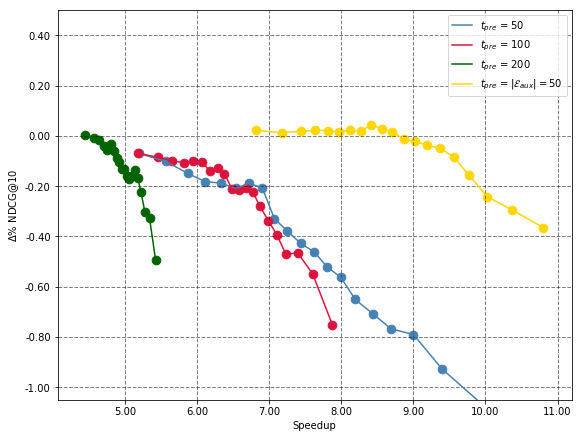

In [31]:
for dataset_name in progressbar(datasets_name):
    dataset = classification_datasets[dataset_name][split]
    end_scores = y_pred_along_training[dataset_name][split][:, -1]
    n = dataset.n_instances
    m = y_pred_along_training[dataset_name][split].shape[1]
    aux_t = y_pred_along_training_aux_10[dataset_name][split].shape[1]
    base_cost = n * m
    base_perf = ndcg_10.eval(dataset, end_scores)
    plt.figure(figsize=(8,6))
    
    
    for position in progressbar(positions):
        print(f'--------{position}-----------')
        sentinel_scores = y_pred_along_training[dataset_name][split][:, position-1]
        X = get_features(dataset, sentinel_scores)
        clf = lgb_classifiers[dataset_name][Strategy.SENT][position][k_s]
        clf_t = clf.num_trees()
        confidences = clf.predict(X)
        speedups, metrics, stat_diffs = [], [], []
        for ct in progressbar(np.linspace(0.1, 0.90, 20)):
            y_pred = confidences > ct
            n_C = y_pred.sum()
            masked_scores = mask_scores(y_pred, sentinel_scores, end_scores)
            cost = n * position + n * clf_t + n_C * (m - position) 
            perf = ndcg_10.eval(dataset, masked_scores)
            delta = -100 * (base_perf[0] - perf[0])/base_perf[0]
            speedup = base_cost / cost
            pvalue = ptest(base_perf[1], perf[1])[1]
            stat_diff = pvalue < alpha
            stat_diffs.append(stat_diff)
            speedups.append(speedup)
            metrics.append(delta)
            print(f'LEAR {position} {ct:.2f}:: {perf[0]:.4f} ({delta:.2f}%) {speedup:.2f}x')
        stat_diffs = np.array(stat_diffs)
        speedups = np.array(speedups)
        metrics = np.array(metrics)
        
        plt.plot(speedups, metrics, label=rf'$t_{{pre}}$ = {position}', color=colors_lear[position])
        plt.scatter(speedups[stat_diffs], metrics[stat_diffs], marker='d', s=75, c=colors_lear[position])
        plt.scatter(speedups[~stat_diffs], metrics[~stat_diffs], marker='o', s=75, c = colors_lear[position])    
    
    
    print('-----AUX------')
    sentinel_scores = y_pred_along_training_aux_10[dataset_name][split][:, -1]
    X = get_features(dataset, sentinel_scores)
    clf = lgb_classifiers[dataset_name][Strategy.AUX][50][k_s]
    clf_t = clf.num_trees()
    confidences = clf.predict(X)
    speedups, metrics, stat_diffs = [], [], []
    for ct in progressbar(np.linspace(0.1, 0.90, 20)):
        y_pred = confidences > ct
        n_C = y_pred.sum()
        masked_scores = mask_scores(y_pred, sentinel_scores, end_scores)
        cost = n * aux_t + n * clf_t + n_C * m 
        perf = ndcg_10.eval(dataset, masked_scores)
        speedup = base_cost / cost
        delta = -100 * (base_perf[0]- perf[0])/base_perf[0]
        speedups.append(speedup)
        metrics.append(delta)
        pvalue = ptest(base_perf[1], perf[1])[1]
        stat_diff = pvalue < alpha
        stat_diffs.append(stat_diff)
        print(f'LEAR {strategy} {ct:.2f}:: {perf[0]:.4f} ({delta:.2f}%) {speedup:.2f}x')
    print('---------')
    speedups = np.array(speedups)
    metrics = np.array(metrics)
    stat_diffs = np.array(stat_diffs)
    
    plt.plot(speedups, metrics, color=colors_lear['aux'], label=rf'$t_{{pre}}$ = |$\mathcal{{E}}_{{aux}}| = 50$')
    plt.scatter(speedups[stat_diffs], metrics[stat_diffs], marker='d', s=75, c=colors_lear['aux'])
    plt.scatter(speedups[~stat_diffs], metrics[~stat_diffs], marker='o', s=75, c = colors_lear['aux'])
    
    plt.ylim((-1.05, 0.5))
    plt.grid(color='black', linestyle='--', linewidth=1, alpha=0.5)
    plt.xlabel('Speedup')
    plt.ylabel(r'$\Delta$% NDCG@10')
    plt.legend()
    y_ticks = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:.2f}'.format(x) for x in y_ticks])
    
    x_ticks = plt.gca().get_xticks()
    plt.gca().set_xticklabels(['{:.2f}'.format(x) for x in x_ticks])
    
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.savefig(f'./images/lear_aux_{dataset_name}.pdf', format='pdf', bbox_inches = "tight")
    plt.show()

In [32]:
gc.collect()

32843

In [33]:
best_positions[msn_name]['LEAR'] = {
            Strategy.SENT: 50,
            Strategy.AUX:  50
}
best_positions[istella_name]['LEAR'] = {
            Strategy.SENT: 100,
            Strategy.AUX:  50
}

best_thresholds[msn_name]['LEAR'] = {
            Strategy.SENT: [0.82, 0.65],
            Strategy.AUX:  [0.86, 0.61]
}
best_thresholds[istella_name]['LEAR'] = {
            Strategy.SENT: [0.44, 0.31],
            Strategy.AUX:  [0.77, 0.44]
}

### Compare best choices on the test set

In [34]:
dcg_10 = SDCG(cutoff=10, implementation='exp')
ndcg_10 = SNDCG(cutoff=10, implementation='exp', no_relevant_results=1.0)

In [35]:
def compute_sizes(dataset, mask):
    sizes = np.zeros((dataset.n_queries,))
    for rel_id, (qid, start, end) in enumerate(dataset.query_iterator()):
        query_mask = mask[start:end]
        sizes[rel_id] = query_mask.sum()
    
    return np.mean(sizes), np.std(sizes)

In [36]:
k_s = 10
split = 'test'
alpha= 0.05

EPT

In [37]:
for dataset_name in progressbar(datasets_name):
    dataset = classification_datasets[dataset_name][split]
    end_scores = y_pred_along_training[dataset_name][split][:, -1]
    n = dataset.n_instances
    m = y_pred_along_training[dataset_name][split].shape[1]
    base_ndcg = ndcg_10.eval(dataset, end_scores) 
    full_cost = n * m
    aux_t = y_pred_along_training_aux_10[dataset_name][split].shape[1]
    y_true = get_oracle(dataset, end_scores, k=k_s)
    
    
    ### prefix
    print(f'{dataset_name}: {base_ndcg[0]:.4f}')
    s = best_positions[dataset_name]['EPT'][Strategy.SENT]
    sentinel_scores = y_pred_along_training[dataset_name][split][:, s -1]
    for pt in best_thresholds[dataset_name]['EPT'][Strategy.SENT]:
        mask = EPT_mask(dataset, sentinel_scores, k=10, pt=pt)
        np.savetxt(fname=f'./data/bin_labels/{dataset_name}_EPT_prefix_{pt:.2f}.txt', X=mask, fmt='%1d')
        n_passed = mask.sum()
        scores = mask_scores(mask, sentinel_scores, end_scores)
        metric = ndcg_10.eval(dataset, scores)
        pvalue = ptest(base_ndcg[1], metric[1])[1]
        stat_diff = pvalue < alpha
        delta = -100*(base_ndcg[0]-metric[0])/base_ndcg[0]
        cost = n * s + n_passed * (m - s)
        speedup = full_cost / cost
        sizes = compute_sizes(dataset, mask)
        df = pandas.DataFrame(np.hstack((np.reshape(base_ndcg[1], (base_ndcg[1].size,1)), np.reshape(metric[1], (metric[1].size,1)))), columns=['base', 'masked'])
        print(f'pvalue = {pvalue:.2f} | H1? {stat_diff}')
        print(f'prefix (s = {s}, pt = {pt:.2f}) -> ndcg = {metric[0]:.4f} ({delta:.2f}%) {speedup:.2f}x | mu = {sizes[0]:.2f} | std = {sizes[1]:.2f}')
        print(classification_report(y_pred=mask, y_true=y_true))
        print('#########################################')
    
    ### aux
    sentinel_scores = y_pred_along_training_aux_10[dataset_name][split][:, -1]
    for pt in best_thresholds[dataset_name]['EPT'][Strategy.AUX]:
        mask = EPT_mask(dataset, sentinel_scores, k=10, pt=pt)
        np.savetxt(fname=f'./data/bin_labels/{dataset_name}_EPT_aux_{pt:.2f}.txt', X=mask, fmt='%1d')
        n_passed = mask.sum()
        scores = mask_scores(mask, sentinel_scores, end_scores)
        metric = ndcg_10.eval(dataset, scores)
        delta = -100*(base_ndcg[0]-metric[0])/base_ndcg[0]
        cost = n * aux_t + n_passed * m
        speedup = full_cost / cost
        sizes = compute_sizes(dataset, mask)
        pvalue = ptest(base_ndcg[1], metric[1])[1]
        stat_diff = pvalue < alpha
        print(f'pvalue = {pvalue:.2f} | H1? {stat_diff}')
        print(f'aux(pt = {pt:.2f}) -> ndcg = {metric[0]:.4f} ({delta:.2f}%) {speedup:.2f}x | mu = {sizes[0]:.2f}, std = {sizes[1]:.2f}')
        print(classification_report(y_pred=mask, y_true=y_true))
    
    print()

  0%|          | 0/2 [00:00<?, ?it/s]

MSN30KF1: 0.5233
pvalue = 0.83 | H1? False
prefix (s = 200, pt = 0.36) -> ndcg = 0.5224 (-0.17%) 3.15x | mu = 20.39 | std = 8.28
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94    710638
         1.0       0.33      0.99      0.49     42973

    accuracy                           0.88    753611
   macro avg       0.66      0.93      0.71    753611
weighted avg       0.96      0.88      0.91    753611

#########################################
pvalue = 0.86 | H1? False
prefix (s = 200, pt = 0.42) -> ndcg = 0.5226 (-0.14%) 3.00x | mu = 22.70 | std = 9.94
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92    710638
         1.0       0.30      0.99      0.46     42973

    accuracy                           0.87    753611
   macro avg       0.65      0.93      0.69    753611
weighted avg       0.96      0.87      0.90    753611

#########################################
pvalue = 0.84 | H1? F

LEAR

In [38]:
dcg_10 = SDCG(cutoff=10, implementation='exp')
ndcg_10 = SNDCG(cutoff=10, implementation='exp', no_relevant_results=1.0)

In [39]:
for dataset_name in progressbar(datasets_name):
    dataset = classification_datasets[dataset_name][split]
    end_scores = y_pred_along_training[dataset_name][split][:, -1]
    n = dataset.n_instances
    m = y_pred_along_training[dataset_name][split].shape[1]
    base_ndcg = ndcg_10.eval(dataset, end_scores)
    full_cost = n * m
    aux_t = y_pred_along_training_aux_10[dataset_name][split].shape[1]
    fsizes = compute_sizes(dataset, np.ones((dataset.n_instances,)))
    y_true = get_oracle(dataset, end_scores, k=k_s)
    
    ### prefix
    print(f'{dataset_name}: {base_ndcg[0]:.4f} | mu = {fsizes[0]:.2f}, std = {fsizes[1]:.2f}' )
    s = best_positions[dataset_name]['LEAR'][Strategy.SENT]
    sentinel_scores = y_pred_along_training[dataset_name][split][:, s -1]
    X = get_features(dataset, sentinel_scores)
    clf = lgb_classifiers[dataset_name][Strategy.SENT][s][k_s]
    clf_t = clf.num_trees()
    y_pred = clf.predict(X)
    for ct in best_thresholds[dataset_name]['LEAR'][Strategy.SENT]:
        mask = y_pred > ct
        np.savetxt(fname=f'./data/bin_labels/{dataset_name}_LEAR_prefix_{ct:.2f}.txt', X=mask, fmt='%1d')
        n_passed = mask.sum()
        scores = mask_scores(mask, sentinel_scores, end_scores)
        metric = ndcg_10.eval(dataset, scores)
        delta = -100*(base_ndcg[0]-metric[0])/base_ndcg[0]
        cost = n * s + n*clf_t + n_passed * (m - s)
        speedup = full_cost / cost
        pvalue = ptest(base_ndcg[1], metric[1])[1]
        stat_diff = pvalue < alpha
        sizes = compute_sizes(dataset, mask)
        print(f'pvalue = {pvalue:.2f} | H1? {stat_diff}')
        print(f'prefix(s = {s}, ct = {ct:.2f}) -> ndcg = {metric[0]:.4f} ({delta:.2f}%) {speedup:.2f}x | mu = {sizes[0]:.2f}, std = {sizes[1]:.2f}')
        print(classification_report(y_pred=mask, y_true=y_true))
    
    print('##########################')
    ### aux
    sentinel_scores = y_pred_along_training_aux_10[dataset_name][split][:, -1]
    X = get_features(dataset, sentinel_scores)
    s = best_positions[dataset_name]['LEAR'][Strategy.AUX]
    clf = lgb_classifiers[dataset_name][Strategy.AUX][50][k_s]
    clf_t = clf.num_trees()
    y_pred = clf.predict(X)
    for ct in best_thresholds[dataset_name]['LEAR'][Strategy.AUX]:
        mask = y_pred > ct
        np.savetxt(fname=f'./data/bin_labels/{dataset_name}_LEAR_aux_{ct:.2f}.txt', X=mask, fmt='%1d')
        n_passed = mask.sum()
        scores = mask_scores(mask, sentinel_scores, end_scores)
        metric = ndcg_10.eval(dataset, scores)
        delta = -100*(base_ndcg[0]-metric[0])/base_ndcg[0]
        cost = n * aux_t + n_passed * m
        speedup = full_cost / cost
        sizes = compute_sizes(dataset, mask)
        pvalue = ptest(base_ndcg[1], metric[1])[1]
        stat_diff = pvalue < alpha
        print(f'pvalue = {pvalue:.2f} | H1? {stat_diff}')
        print(f'aux(ct = {ct:.2f}) -> ndcg = {metric[0]:.4f} ({delta:.2f}%) {speedup:.2f}x | mu = {sizes[0]:.2f}, std = {sizes[1]:.2f}')
        print(classification_report(y_pred=mask, y_true=y_true))

  0%|          | 0/2 [00:00<?, ?it/s]

MSN30KF1: 0.5233 | mu = 119.51, std = 71.83
pvalue = 0.57 | H1? False
prefix(s = 50, ct = 0.82) -> ndcg = 0.5210 (-0.44%) 5.47x | mu = 16.23, std = 6.47
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95    710638
         1.0       0.38      0.91      0.54     42973

    accuracy                           0.91    753611
   macro avg       0.69      0.91      0.74    753611
weighted avg       0.96      0.91      0.93    753611

pvalue = 0.87 | H1? False
prefix(s = 50, ct = 0.65) -> ndcg = 0.5226 (-0.13%) 4.50x | mu = 21.17, std = 8.41
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    710638
         1.0       0.31      0.95      0.46     42973

    accuracy                           0.87    753611
   macro avg       0.65      0.91      0.70    753611
weighted avg       0.96      0.87      0.90    753611

##########################
pvalue = 0.67 | H1? False
aux(ct = 0.86) -> ndcg = 0.5216

In [40]:
alpha

0.05

### QuickScorer

In [41]:
dcg_10 = SDCG(cutoff=10, implementation='exp')
ndcg_10 = SNDCG(cutoff=10, implementation='exp', no_relevant_results=1.0)

In [42]:
execution_times = pd.read_csv('./data/runtimes.csv', decimal='.')
execution_times.head()

,dataset,strategy,model_type,parameter,dataset_time,doc_time
0,MSN30KF1,aux,ranker,0.0,1.526410,2.025400e-06
1,MSN30KF1,aux,clf,0.0,0.404605,5.368880e-07
2,MSN30KF1,prefix,clf,0.0,0.498687,6.617299e-07
3,ISTELLA-FULL,aux,ranker,0.0,5.790620,1.850630e-06
4,ISTELLA-FULL,aux,clf,0.0,1.004650,3.210766e-07


In [43]:
proximity_thresholds = np.array(sorted(list(set(execution_times.query('model_type == \'ept\'')['parameter'].values))))
confidence_thresholds = np.array(sorted(list(set(execution_times.query('model_type == \'lear\'')['parameter'].values))))

In [44]:
split = 'test'

In [45]:
true_performances = {}
for dataset_name in datasets_name:
    true_performances[dataset_name] = {
        'prefix' : {'ept' : { pt: {} for pt in proximity_thresholds},
                    'clf' : { ct: {} for ct in confidence_thresholds},
                   },
        'aux' : {'ept' : { pt: {} for pt in proximity_thresholds},
                 'clf' : { ct: {} for ct in confidence_thresholds},
                },
    }

In [46]:
execution_times

,dataset,strategy,model_type,parameter,dataset_time,doc_time
0,MSN30KF1,aux,ranker,0.00,1.526410,2.025400e-06
1,MSN30KF1,aux,clf,0.00,0.404605,5.368880e-07
2,MSN30KF1,prefix,clf,0.00,0.498687,6.617299e-07
3,ISTELLA-FULL,aux,ranker,0.00,5.790620,1.850630e-06
4,ISTELLA-FULL,aux,clf,0.00,1.004650,3.210766e-07
5,ISTELLA-FULL,prefix,clf,0.00,1.322310,4.225977e-07
6,MSN30KF1,baseline,baseline,0.00,21.209100,2.814300e-05
7,ISTELLA-FULL,baseline,baseline,0.00,143.045000,4.571600e-05
8,MSN30KF1,prefix,ept,0.36,11.585840,1.537370e-05
9,MSN30KF1,prefix,ept,0.42,12.174150,1.615440e-05


In [47]:
for dataset_name in progressbar(datasets_name):
    dataset = classification_datasets[dataset_name][split]
    scores = y_pred_along_training[dataset_name][split][:, -1]
    sentinel_position = best_positions[dataset_name]['EPT'][Strategy.SENT]
    exit_point = sentinel_position - 1
    sentinel_scores = y_pred_along_training[dataset_name][split][:, exit_point]
    aux_scores = y_pred_along_training_aux_10[dataset_name][split][:, -1]
    n_items = dataset.n_instances
    n_trees = y_pred_along_training[dataset_name][split].shape[1]
    base_t = execution_times.query(f'dataset == \'{dataset_name}\' and model_type == \'baseline\'')['dataset_time'].values[0]
    for pt in progressbar(proximity_thresholds):
        prefix_ept_mask = EPT_mask(dataset, sentinel_scores, k=10, pt=pt)
        prefix_ept_scores = mask_scores(prefix_ept_mask, sentinel_scores, scores)
        prefix_ept_metric = ndcg_10.eval(dataset, prefix_ept_scores)
        prefix_ept_cost = execution_times.query(f'dataset == \'{dataset_name}\' and strategy == \'prefix\' and model_type == \'ept\' and parameter == \'{pt:.2f}\'')['dataset_time']
        pv_prefix = np.array(random_test(ndcg_10.eval(dataset, scores)[1], prefix_ept_metric[1], n_perm=10))
        aux_ept_mask = EPT_mask(dataset, aux_scores, k=10, pt=pt)
        aux_ept_scores = mask_scores(aux_ept_mask, aux_scores, scores)
        aux_ept_metric = ndcg_10.eval(dataset, aux_ept_scores)
        pv_aux = np.array(random_test(ndcg_10.eval(dataset, scores)[1], aux_ept_metric[1], n_perm=10))
        
        aux_ept_cost = execution_times.query(f'dataset == \'{dataset_name}\' and strategy == \'aux\' and model_type == \'ept\' and parameter == \'{pt:.2f}\'')['dataset_time']
        aux_ept_cost += execution_times.query(f'dataset == \'{dataset_name}\' and strategy == \'aux\' and model_type == \'ranker\'')['dataset_time'].values[0]
        try:
            true_performances[dataset_name]['prefix']['ept'][pt] = {
                'metric': prefix_ept_metric, 
                'cost' : prefix_ept_cost.values[0] ,
                'p_value': pv_prefix
            }
        except IndexError:
            print(f'parameter not found {pt}')
        try:
            true_performances[dataset_name]['aux']['ept'][pt] = {
                'metric': aux_ept_metric, 
                'cost' : aux_ept_cost.values[0],
                'p_value' : pv_aux
            }
        except IndexError:
            print(f'parameter not found {pt}')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

parameter not found 1.12
parameter not found 1.12


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

parameter not found 1.25
parameter not found 1.25


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

parameter not found 1.37
parameter not found 1.37


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

parameter not found 1.5
parameter not found 1.5


  0%|          | 0/6 [00:00<?, ?it/s]

IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

parameter not found 0.36
parameter not found 0.36


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

parameter not found 0.42
parameter not found 0.42


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

parameter not found 1.12


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

parameter not found 1.25


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

parameter not found 1.37


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

parameter not found 1.5


In [48]:
print(classification_datasets[msn_name][split].n_instances)
print(classification_datasets[istella_name][split].n_instances)

753611
3129004


In [49]:
for dataset_name in progressbar(datasets_name):
    dataset = classification_datasets[dataset_name][split]
    scores = y_pred_along_training[dataset_name][split][:, -1]
    sentinel_position = best_positions[dataset_name]['LEAR'][Strategy.SENT]
    exit_point = sentinel_position - 1
    sentinel_scores = y_pred_along_training[dataset_name][split][:, exit_point]
    aux_scores = y_pred_along_training_aux_10[dataset_name][split][:, -1]
    
    classifier_prefix = lgb_classifiers[dataset_name][Strategy.SENT][sentinel_position][k_s]
    classifier_aux = lgb_classifiers[dataset_name][Strategy.AUX][50][k_s]

    X_pr = get_features(dataset, sentinel_scores)
    X_x  = get_features(dataset, aux_scores)
    X_prefix = X_pr
    X_aux = X_x
    
    probs_prefix = classifier_prefix.predict(X_prefix)
    probs_aux = classifier_aux.predict(X_aux)
    
    for ct in progressbar(confidence_thresholds):
        prefix_clf_mask = probs_prefix >= ct
        prefix_clf_scores = mask_scores(prefix_clf_mask, sentinel_scores, scores)
        prefix_clf_metric = ndcg_10.eval(dataset, prefix_clf_scores)
        prefix_clf_cost = execution_times.query(f'dataset == \'{dataset_name}\' and strategy == \'prefix\' and model_type == \'lear\' and parameter == \'{ct:.2f}\'')['dataset_time']
        prefix_clf_cost += execution_times.query(f'dataset == \'{dataset_name}\' and strategy == \'prefix\' and model_type == \'clf\'')['dataset_time'].values[0]
        pv_prefix = np.array(random_test(ndcg_10.eval(dataset, scores)[1], prefix_clf_metric[1], n_perm=10))
        
        aux_clf_mask = probs_aux >= ct
        aux_clf_scores = mask_scores(aux_clf_mask, aux_scores, scores)
        aux_clf_metric = ndcg_10.eval(dataset, aux_clf_scores)
        pv_aux = np.array(random_test(ndcg_10.eval(dataset, scores)[1], aux_clf_metric[1], n_perm=10))
        
        aux_clf_cost = execution_times.query(f'dataset == \'{dataset_name}\' and strategy == \'aux\' and model_type == \'lear\' and parameter == \'{ct:.2f}\'')['dataset_time']
        aux_clf_cost += execution_times.query(f'dataset == \'{dataset_name}\' and strategy == \'aux\' and model_type == \'clf\'')['dataset_time'].values[0]
        aux_clf_cost += execution_times.query(f'dataset == \'{dataset_name}\' and strategy == \'aux\' and model_type == \'ranker\'')['dataset_time'].values[0]
        try:
            true_performances[dataset_name]['prefix']['clf'][ct] = {
                'metric': prefix_clf_metric, 
                'cost' : prefix_clf_cost.values[0],
                'p_value' : pv_prefix
            }
        except IndexError:
            print(f'value not found {ct}')
        try:
            true_performances[dataset_name]['aux']['clf'][ct] = {
                'metric': aux_clf_metric, 
                'cost' : aux_clf_cost.values[0],
                'p_value': pv_aux
            }
        except IndexError:
            print(f'value not found {ct}')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

value not found 0.31
value not found 0.31


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

value not found 0.44
value not found 0.44


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

value not found 0.61


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

value not found 0.65


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

value not found 0.77
value not found 0.77


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

value not found 0.82


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

value not found 0.86


  0%|          | 0/7 [00:00<?, ?it/s]

IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

value not found 0.31


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

value not found 0.61
value not found 0.61


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

value not found 0.65
value not found 0.65


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

value not found 0.77


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

value not found 0.82
value not found 0.82


IntProgress(value=0, description='Randomization Test', max=10)

IntProgress(value=0, description='Randomization Test', max=10)

value not found 0.86
value not found 0.86


In [50]:
alpha = 0.05

In [51]:
for dataset_name in tqdm.notebook.tqdm(datasets_name, leave=False):
    base_t = execution_times.query(f'dataset == \'{dataset_name}\' and model_type == \'baseline\'')['dataset_time'].values[0]
    for kind in ['prefix', 'aux']:
        for strategy in ['ept', 'clf']:
            for threshold, performances in true_performances[dataset_name][kind][strategy].items():
                if len(performances) > 0:
                    print(dataset_name, kind, strategy, threshold, performances['metric'][0], base_t / performances['cost'])
            
            print()
    print()

  0%|          | 0/2 [00:00<?, ?it/s]

MSN30KF1 prefix ept 0.36 0.5223752 1.830605290596107
MSN30KF1 prefix ept 0.42 0.52255213 1.7421421618757778

MSN30KF1 prefix clf 0.65 0.52260834 3.1404153964176422
MSN30KF1 prefix clf 0.82 0.5209759 3.6811978615862935

MSN30KF1 aux ept 0.36 0.52245474 3.778863833972376
MSN30KF1 aux ept 0.42 0.5223965 3.5380932521478017

MSN30KF1 aux clf 0.61 0.5230883 3.495741393163978
MSN30KF1 aux clf 0.86 0.5215613 4.184579141917708


ISTELLA-FULL prefix ept 1.37 0.73079413 5.735703344908057
ISTELLA-FULL prefix ept 1.5 0.73114705 5.515668439094172

ISTELLA-FULL prefix clf 0.31 0.73108965 5.141747162414796
ISTELLA-FULL prefix clf 0.44 0.73072326 5.481279272989511

ISTELLA-FULL aux ept 1.12 0.73043287 9.681071810954984
ISTELLA-FULL aux ept 1.25 0.73084366 9.373982210764368

ISTELLA-FULL aux clf 0.44 0.7311051 7.702157056267825
ISTELLA-FULL aux clf 0.77 0.7303909 8.99349779760056


